[Local Guide File Path](/home/carles/Documents/MIRI/FRR/PDF/GuideLine3.pdf).

### cube map that stores diffuse irradiance
INPUT: Six separated images that represent a cube map.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
%matplotlib widget


In [327]:
class CubeMap():
    def __init__(self) -> None:
        self.resolution = (0,0,0)
        self.cube_map = {
            'back':None, 
            'front':None, 
            'left':None, 
            'right':None, 
            'top':None, 
            'bottom':None}
        self.cube_map_diffuse = {
            'back':None, 
            'front':None, 
            'left':None, 
            'right':None, 
            'top':None, 
            'bottom':None}
        self.id_tag = {
            0:"right",
            1:"left",
            2:"back",
            3:"front",
            4:"top",
            5:"bottom",
            "right"  :0,
            "left"   :1,
            "back"   :2,
            "front"  :3,
            "top"    :4,
            "bottom" :5,}

    def _generate_cubemap_diffuse(self):
        black_image = np.zeros(self.resolution,dtype=np.float32)
        for i in self.cube_map_diffuse.keys():
            self.cube_map_diffuse[i]=black_image

    def load_cubemap(self, folder_path):
        # Define the expected image file names
        image_names = ['back', 'front', 'left', 'right', 'top', 'bottom']

        # Iterate through the image names
        for name in image_names:
            # Construct the full path to the image file
            image_path = os.path.join(folder_path, f"{name}.png")  # Adjust the file extension as needed

            # Check if the file exists
            if os.path.exists(image_path):
                # Load the image using Pillow
                image = Image.open(image_path)
                image = np.array(image,dtype=np.float32)/255 
                image = np.rot90(image[:,:,:3],k=1)
                if name in ["top","bottom"]:
                    image = np.rot90(image[:,:,:3],k=2)

                # Add the image to the cube_map dictionary
                self.cube_map[name] = image
            else:
                print(f"Image file '{name}.png' not found in the folder.")
        self.resolution = image.shape

    def plot(self,images=None):
        if images==None:
            images = self.cube_map

        # Generate big image:
        image = np.zeros((self.resolution[1]*3, self.resolution[0]*4, 3), dtype=np.float32)

        # TOP
        image[0:self.resolution[0], self.resolution[1]:self.resolution[1]*2]=np.flip(np.rot90(images["top"][:,:,:3], k=3),axis=(1))
        # LEFT
        image[self.resolution[0]:self.resolution[0]*2, 0:self.resolution[1]]=np.flip(np.rot90(images["left"][:,:,:3], k=3),axis=(1))
        # FRONT
        image[self.resolution[0]:self.resolution[0]*2, self.resolution[1]:self.resolution[1]*2]=np.flip(np.rot90(images["front"][:,:,:3], k=3),axis=(1))
        # RIGHT
        image[self.resolution[0]:self.resolution[0]*2, self.resolution[1]*2:self.resolution[1]*3]=np.flip(np.rot90(images["right"][:,:,:3], k=3),axis=(1))
        # BACK
        image[self.resolution[0]:self.resolution[0]*2, self.resolution[1]*3:self.resolution[1]*4]=np.flip(np.rot90(images["back"][:,:,:3], k=3),axis=(1))
        # BOTTOM
        image[self.resolution[0]*2:self.resolution[0]*3, self.resolution[1]:self.resolution[1]*2]=np.flip(np.rot90(images["bottom"][:,:,:3], k=3),axis=(1))

        # Create a new figure
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.imshow(image)
        plt.show()

    def _normal_to_pixel(self,normal):
        # Normalize the normal vector
        normal /= np.linalg.norm(normal)

        # Determine which face of the cube the normal intersects
        abs_normal = np.abs(normal)
        max_index = np.argmax(abs_normal)
        face_index = max_index * 2 + (normal[max_index] < 0)
        
        # Map the normalized normal vector onto the 2D texture coordinates of the chosen face
        u, v = 0, 0
        if face_index == 0:
            if abs_normal[0] != 0:
                u = 1-(normal[2] / abs_normal[0] * 0.5 + 0.5)
                v = normal[1] / abs_normal[0] * 0.5 + 0.5
        elif face_index == 1:  # Right or Left face
            if abs_normal[0] != 0:
                u = 1-(normal[2] / abs_normal[0] * 0.5 + 0.5)
                v = 1-(normal[1] / abs_normal[0] * 0.5 + 0.5)
        elif face_index == 2:  # Top or Bottom face
            if abs_normal[1] != 0:
                u = 1-(normal[0] / abs_normal[1] * 0.5 + 0.5)
                v = 1-(normal[2] / abs_normal[1] * 0.5 + 0.5)
        elif face_index == 3:  # Top or Bottom face
            if abs_normal[1] != 0:
                u = normal[0] / abs_normal[1] * 0.5 + 0.5
                v = 1-(normal[2] / abs_normal[1] * 0.5 + 0.5)
        elif face_index == 4:  # Top or Bottom face
            if abs_normal[1] != 0:
                u = normal[0] / abs_normal[2] * 0.5 + 0.5
                v = 1-(normal[1] / abs_normal[2] * 0.5 + 0.5)
        elif face_index == 5:  # Front or Back face
            if abs_normal[2] != 0:
                u = normal[0] / abs_normal[2] * 0.5 + 0.5
                v = normal[1] / abs_normal[2] * 0.5 + 0.5
        
        # Map the texture coordinates to pixel coordinates within the image
        image_width, image_height = self.resolution[:2]  # Assuming all images have the same size
        pixel_u = int(u * (image_width - 1))
        pixel_v = int(v * (image_height - 1))

        # Return the pixel coordinates and the image
        return pixel_u, pixel_v, face_index

    def _pixel_to_normal(self, x, y, face):
        u = (2 * x + 1) / self.resolution[0] - 1
        v = (2 * y + 1) / self.resolution[0] - 1
        if face == 0:  # +X face
            return np.array([1, v, -u])
        elif face == 1:  # -X face
            return np.array([-1, -v, -u])
        elif face == 2:  # +Y face
            return np.array([-u, 1, -v])
        elif face == 3:  # -Y face
            return np.array([u, -1, -v])
        elif face == 4:  # +Z face
            return np.array([u, -v, 1])
        elif face == 5:  # -Z face
            return np.array([-u, -v, -1])

    def _get_color(self,x:int,y:int,f:int):
        f = self.id_tag[f]
        color = self.cube_map[f][x,y]
        return color[:3]

    def _normals_to_cube(self, normals):
        for n in normals:
            print(self._normal_to_pixel(n))

    def _get_tag(self,id):
        return self.id_tag[id]

    def _rotation_matrix_from_vectors(self, vec1, vec2):
        # Ensure the vectors are normalized
        vec1 = vec1 / np.linalg.norm(vec1)
        vec2 = vec2 / np.linalg.norm(vec2)

        # Calculate the cross product and dot product
        cross = np.cross(vec1, vec2)
        dot = np.dot(vec1, vec2)

        # Calculate the skew-symmetric cross product matrix
        skew_cross = np.array([[0, -cross[2], cross[1]],
                            [cross[2], 0, -cross[0]],
                            [-cross[1], cross[0], 0]])

        # Calculate the rotation matrix
        rotation_matrix = np.eye(3) + skew_cross + np.dot(skew_cross, skew_cross) * (1 / (1 + dot))

        return rotation_matrix
    
    def _random_radiance_normal(self, u, N=50):

        R = np.random.randn(N, 3)
        R[:, 2] = np.abs(R[:, 2])
        R = R / np.sqrt(np.sum(R**2, axis=1, keepdims=True))

        # Define the normal direction u
        u = u / np.linalg.norm(u)  # Ensure u is normalized

        # Calculate rotation matrix to align points with the normal direction u
        rotation_matrix = self._rotation_matrix_from_vectors(np.array([0, 0, 1]), u)

        # Rotate the points
        R_rotated = np.dot(R, rotation_matrix.T).T 
        return R_rotated
    
    def generate_diffuse(self):
        
        
        pass

    def plot_normal(self, vector, red_vector=[0,0,0]):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # for v in vector:
        ax.quiver(0, 0, 0, *vector)
        
        # for u in red_vector:
        ax.quiver(0, 0, 0, *red_vector, color=(1,0,0))

        # draw cube
        r = [-1,1]
        X, Y = np.meshgrid(r, r)
        X=np.array(X,dtype=np.float32)*.6
        Y=np.array(Y,dtype=np.float32)*.6
        Z = np.array([[1.,1.],[1.,1.]])*.6
        ax.plot_surface(X,Y,Z, alpha=0.5)
        ax.plot_surface(X,Y,-Z, alpha=0.5)
        ax.plot_surface(X,-Z,Y, alpha=0.5)
        ax.plot_surface(X,Z,Y, alpha=0.5)
        ax.plot_surface(Z,X,Y, alpha=0.5)
        ax.plot_surface(-Z,X,Y, alpha=0.5)

        # draw sphere
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = np.cos(u)*np.sin(v)*.5
        y = np.sin(u)*np.sin(v)*.5
        z = np.cos(v)*.5
        ax.plot_surface(x, y, z, color=(.2,.0,.8,.2))
        
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_aspect("equal")
        
        plt.show()


## 1.
### We first load the cube map images

In [328]:
cubemap_instance = CubeMap()
cubemap_instance.load_cubemap("./test_images")

In [222]:
# test temporal dels pixel to normal
_=np.linspace(0,255//2,10,dtype=np.int32)
new_normals_0=[]
new_normals_1=[]
new_normals_2=[]
new_normals_3=[]
new_normals_4=[]
new_normals_5=[]
for i in _:
    normals_=cubemap_instance._pixel_to_normal(i,i,0)
    new_normals_0.append(normals_/np.linalg.norm(normals_))
    normals_=cubemap_instance._pixel_to_normal(i,i,1)
    new_normals_1.append(normals_/np.linalg.norm(normals_))
    normals_=cubemap_instance._pixel_to_normal(i,i,2)
    new_normals_2.append(normals_/np.linalg.norm(normals_))
    normals_=cubemap_instance._pixel_to_normal(i,i,3)
    new_normals_3.append(normals_/np.linalg.norm(normals_))
    normals_=cubemap_instance._pixel_to_normal(i,i,4)
    new_normals_4.append(normals_/np.linalg.norm(normals_))
    normals_=cubemap_instance._pixel_to_normal(i,i,5)
    new_normals_5.append(normals_/np.linalg.norm(normals_))
new_normals_0=np.array(new_normals_0)
new_normals_1=np.array(new_normals_1)
new_normals_2=np.array(new_normals_2)
new_normals_3=np.array(new_normals_3)
new_normals_4=np.array(new_normals_4)
new_normals_5=np.array(new_normals_5)
# print(np.array(new_normals))


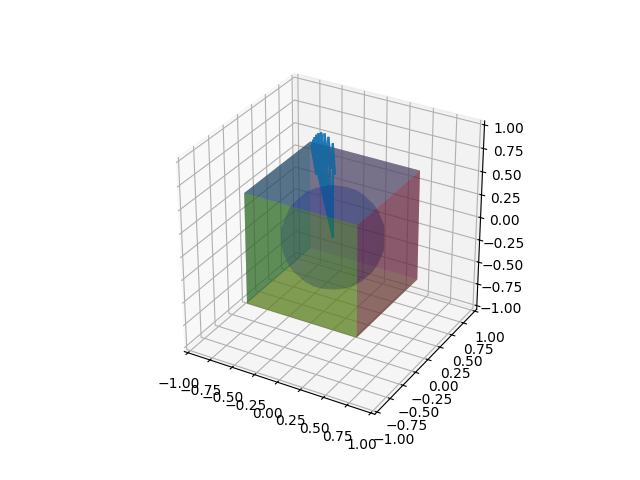

In [223]:
cubemap_instance.plot_normal(new_normals_4.T)

### We check the result of the cube

This will look correct if the images used for the cube are on the same oriantation as the ones used by opengl. Make sure they look correct on opengl cubemap before importing them to the python program.

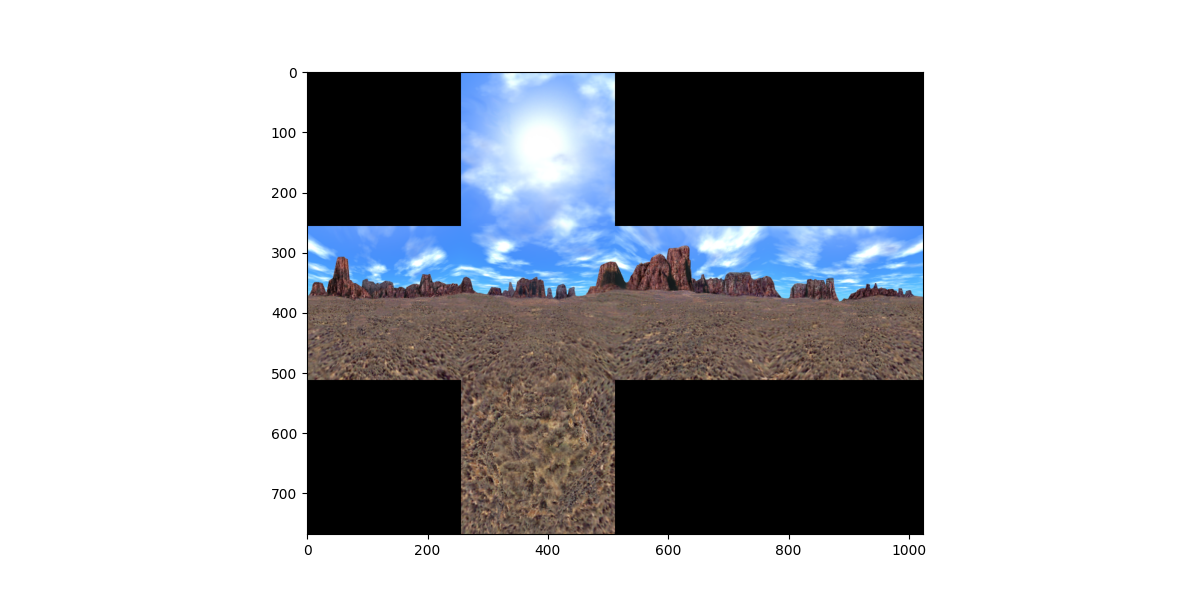

In [144]:
cubemap_instance.plot()

## 2.
### Vectors
We now are capable of obtaining the normals that represent the pixels of the cube to make operations on them

In [329]:
x, y, face = 20, 20, 4 # Example pixel coordinates and face

# Obtain normal
normal = cubemap_instance._pixel_to_normal(x, y, face)
print(f"original pixel {x,y}")
print("Normal vector:", normal/np.linalg.norm(normal))

# Obtain pixel
px, py, pf = cubemap_instance._normal_to_pixel(normal)
print(f"Pixel coordinates on face {pf} => x:{px}, y:{py}")

original pixel (20, 20)
Normal vector: [-0.54091517  0.54091517  0.64406643]
Pixel coordinates on face 4 => x:20, y:20


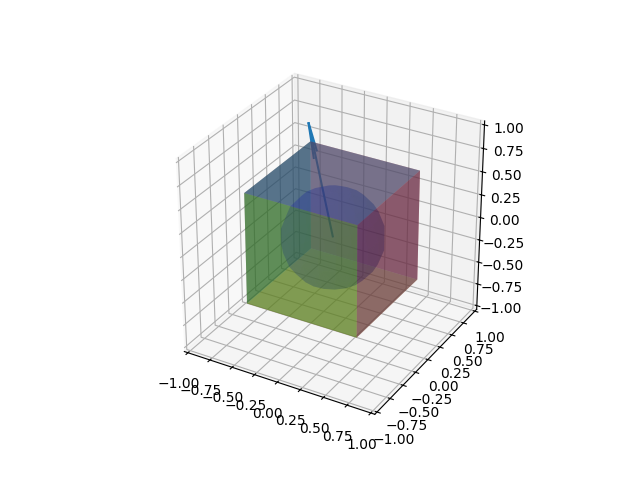

In [330]:
cubemap_instance.plot_normal(normal*1.2)

## 3.
We can generate the hemisphere vectors on random distribution on one direction as follows:

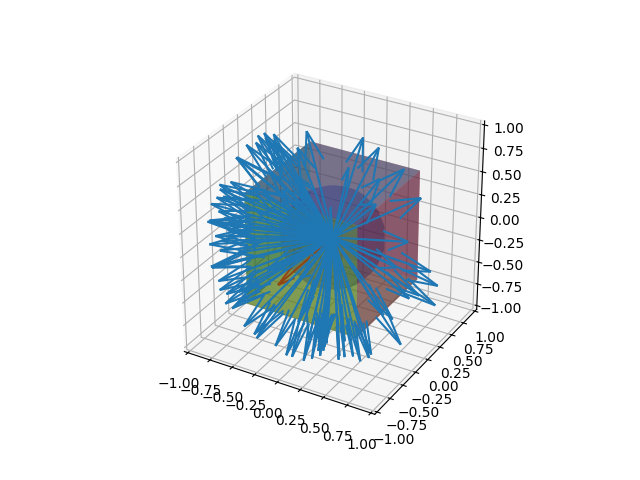

In [149]:
direction = np.array([0,-1,0])
quantity = 100

# Normal list format:
# [
# [x0,x1,x2...],
# [y0,y1,y2...],
# [z0,z1,z2...]
# ]
normal_list=cubemap_instance._random_radiance_normal(direction,quantity)
cubemap_instance.plot_normal(normal_list*1.2,direction)

## Cube projection
This is the code to obtain the projected cube based on normals.

For this example, the code will run over all posible pixels and faces to get the projected color for each normal

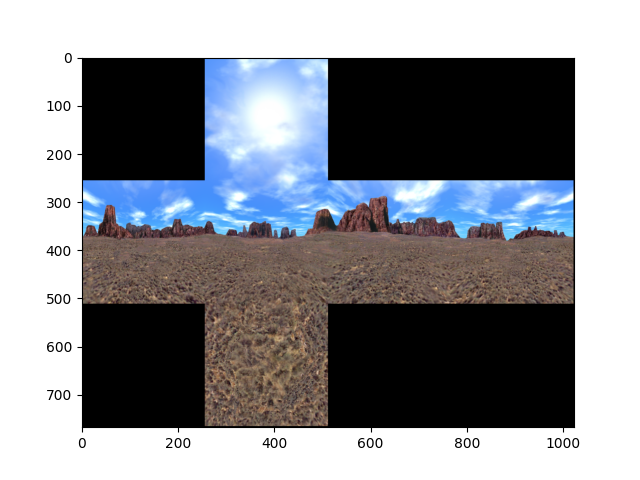

In [164]:
fig = plt.figure()
ax = fig.add_subplot(111)
w,h,c=cubemap_instance.resolution
img = np.zeros((w*3,h*4,3))

for f in range(6):
    for x in range(cubemap_instance.resolution[0]):
        for y in range(cubemap_instance.resolution[1]):
            if f==0:
                img[y+h,x+w*2-2]=cubemap_instance._get_color(x,y,f)
            if f==1:
                img[y+h,x]=cubemap_instance._get_color(x,y,f)
            if f==2:
                img[y+h,x+w*3-3]=cubemap_instance._get_color(x,y,f)
            if f==3:
                img[y+h,x+w-1]=cubemap_instance._get_color(x,y,f)
            if f==4:
                img[y,x+w-1]=cubemap_instance._get_color(x,y,f)
            if f==5:
                img[y+2*h-2,x+w-1]=cubemap_instance._get_color(x,y,f)

ax.imshow(img)
plt.show()


Calculating diffuse map

progress 0.00
progress 0.01
progress 0.02
progress 0.03
progress 0.04
progress 0.05
progress 0.06
progress 0.07
progress 0.08
progress 0.09
progress 0.10
progress 0.11
progress 0.12
progress 0.13
progress 0.14
progress 0.15
progress 0.16
progress 0.17
progress 0.18
progress 0.19
progress 0.20
progress 0.21
progress 0.22
progress 0.23
progress 0.24
progress 0.25
progress 0.26
progress 0.27
progress 0.28
progress 0.29
progress 0.30
progress 0.31
progress 0.32
progress 0.33
progress 0.34
progress 0.35
progress 0.36
progress 0.37
progress 0.38
progress 0.39
progress 0.40
progress 0.41
progress 0.42
progress 0.43
progress 0.44
progress 0.45
progress 0.46
progress 0.47
progress 0.48
progress 0.49
progress 0.50
progress 0.51
progress 0.52
progress 0.53
progress 0.54
progress 0.55
progress 0.56
progress 0.57
progress 0.58
progress 0.59
progress 0.60
progress 0.61
progress 0.62
progress 0.63
progress 0.64
progress 0.65
progress 0.66
progress 0.67
progress 0.68
progress 0.69
progress 0.70
progre

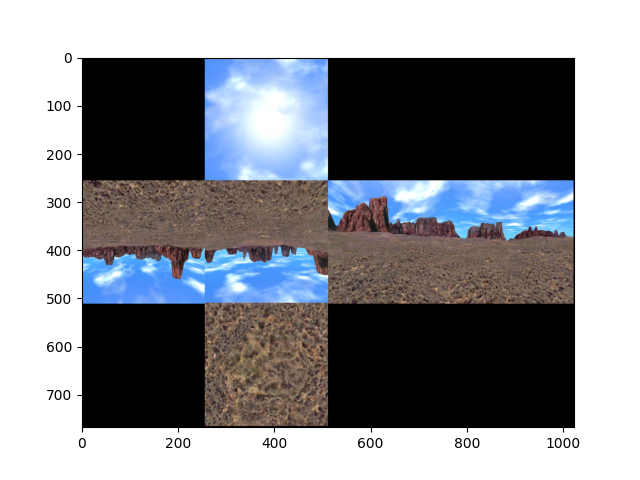

In [299]:
fig = plt.figure()
ax = fig.add_subplot(111)
w,h,c=cubemap_instance.resolution
img = np.zeros((w*3,h*4,3))
prev_prg = ""

for f in range(6):
    for x in range(cubemap_instance.resolution[0]):
        for y in range(cubemap_instance.resolution[1]):
            
            # Original color
            original_color = cubemap_instance._get_color(x,y,f)
            # get normal to calculate hemisphere
            n = cubemap_instance._pixel_to_normal(x,y,f)
            # hemisphere
            normal_list = cubemap_instance._random_radiance_normal(n,1)
            # influencia en el nuevo color?
            for reflacted in normal_list.T:
                reflacted_pix = cubemap_instance._normal_to_pixel(n)
                # reflacted_pix = cubemap_instance._normal_to_pixel(reflacted)
                reflacted_col = cubemap_instance._get_color(*reflacted_pix)
                dot_product = np.dot(n/np.linalg.norm(n), reflacted/np.linalg.norm(reflacted))
                original_color = reflacted_col #reflacted_col*dot_product + original_color*(1-dot_product)

            # Storing on image
            if f==0:
                img[y+h,x+w*2-2]=original_color
            if f==1:
                img[y+h,x]=original_color
            if f==2:
                img[y+h,x+w*3-3]=original_color
            if f==3:
                img[y+h,x+w-1]=original_color
            if f==4:
                img[y,x+w-1]=original_color
            if f==5:
                img[y+2*h-2,x+w-1]=original_color
        
        prg = "progress {:.2f}".format(((cubemap_instance.resolution[0]*f + x) / (6*cubemap_instance.resolution[0])))
        if prev_prg!=prg:
            print(prg)
            prev_prg=prg

ax.imshow(img)
plt.show()